---
---
# **1. Imports**
---
---

In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc
from scipy.stats import ks_2samp
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, auc, \
                            roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve

---
---
# **2. Configuration**
---
---

In [2]:
# Artifact directory
ARTIFACT_DIR = "artifacts_classification"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# Load models
models = {
    "Logistic Regression Tuned": joblib.load("../models/classification/model_package_LogisticRegression_Tuned.pkl"),
    "Random Forest Tuned": joblib.load("../models/classification/model_package_RandomForest_Tuned.pkl"),
    "XGBoost Tuned": joblib.load("../models/classification/model_package_XGBoost_Tuned.pkl")
}

# Load validation data
df_val = pd.read_csv("../qws1_dataset/validation_data_classification.csv")
target = "Class"
X_val = df_val.drop(columns=[target])
y_val = df_val[target]

---
---
# **3. Plotting**
---
---

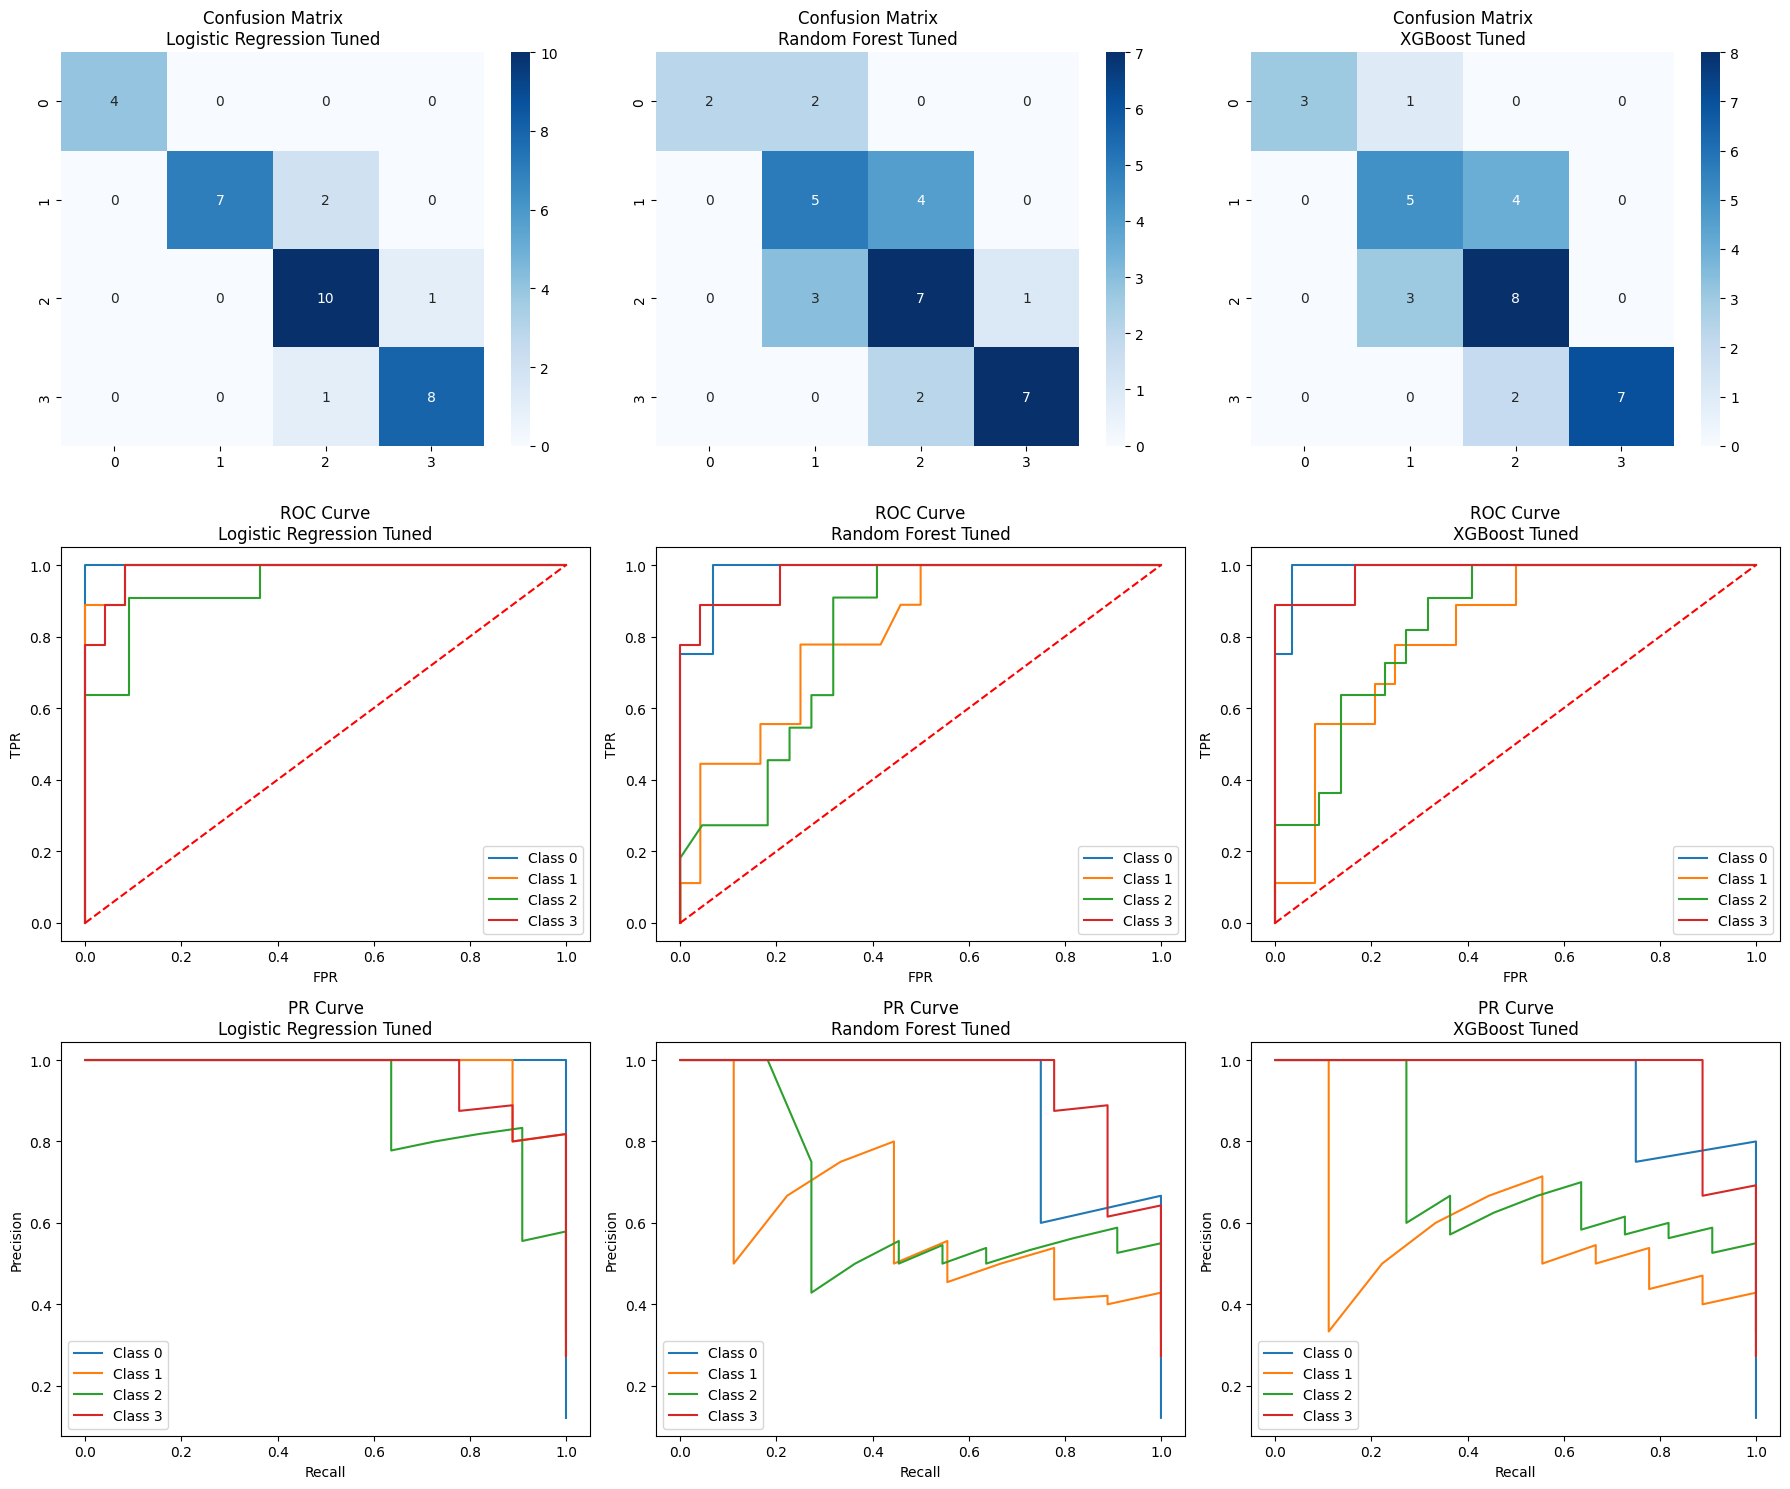

In [3]:
classes = np.unique(y_val)
y_true_bin = label_binarize(y_val, classes=classes)

fig, axes = plt.subplots(3, len(models), figsize=(6 * len(models), 15))

for col, (name, model_info) in enumerate(models.items()):
    m = model_info["model"]
    y_pred_proba = m.predict_proba(X_val)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, col])
    axes[0, col].set_title(f"Confusion Matrix\n{name}")

    # ROC Curve
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        axes[1, col].plot(fpr, tpr, label=f"Class {cls}")
    axes[1, col].plot([0, 1], [0, 1], 'r--')
    axes[1, col].set_title(f"ROC Curve\n{name}")
    axes[1, col].set_xlabel("FPR")
    axes[1, col].set_ylabel("TPR")
    axes[1, col].legend()

    # Precision-Recall Curve
    for i, cls in enumerate(classes):
        prec_curve, rec_curve, _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
        axes[2, col].plot(rec_curve, prec_curve, label=f"Class {cls}")
    axes[2, col].set_title(f"PR Curve\n{name}")
    axes[2, col].set_xlabel("Recall")
    axes[2, col].set_ylabel("Precision")
    axes[2, col].legend()

plt.tight_layout()
plt.savefig(f"{ARTIFACT_DIR}/combined_evaluation_plots.png")
plt.show()

1. Confusion Matrices:
    - Logistic Regression Tuned
        - Most predictions are correct for classes 2 and 3.
        - Minor misclassifications occur between classes 0 and 1.
    - Random Forest Tuned
        - Performs well on class 2 but shows more confusion between classes 0 and 1 compared to Logistic Regression.
        - Class 3 predictions are slightly less accurate than Logistic Regression.
    - XGBoost Tuned
        - Similar to Random Forest, strong performance on class 2, but some misclassification between classes 0 and 1.
        - Overall balanced but slightly less precise than Logistic Regression for class 3.

Logistic Regression shows the most consistent diagonal dominance (better separation), while tree-based models have more overlap between lower classes.

2. ROC Curves:
    - All models show AUC values close to 1.0 for most classes, indicating strong discriminative ability.
    - Logistic Regression: Curves are steep and close to the top-left corner for classes 2 and 3 -> excellent performance.
    - Random Forest & XGBoost: Slightly less steep for class 1, meaning weaker separation for that class compared to Logistic Regression.

All models perform well overall, but Logistic Regression has the most consistent ROC curves across classes.

3. Precision-Recall Curves
    - Logistic Regression: High precision across most recall levels for classes 2 and 3.
    - Random Forest & XGBoost: More variability and lower precision for classes 0 and 1, especially at higher recall.
    - PR curves confirm that minority classes (likely class 0 or 1) are harder to predict accurately for tree-based models.

Logistic Regression maintains better precision-recall trade-offs for dominant classes, while Random Forest and XGBoost struggle more with minority classes.

---
---
# **4. Drift Checks**
---
---

In [4]:
# Load training data
path = '../qws1_dataset/training_data_classification.csv'
df_train = pd.read_csv(path)

# Feature columns
train_col = X_val.columns.tolist()

# Split features
X_train = df_train[train_col]

In [5]:
# Drift Checks
def calculate_psi(expected, actual, buckets=10):
    """Calculate Population Stability Index (PSI)"""
    breakpoints = np.linspace(min(expected.min(), actual.min()), max(expected.max(), actual.max()), buckets + 1)
    expected_counts = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_counts = np.histogram(actual, bins=breakpoints)[0] / len(actual)

    # Avoid division by zero
    expected_counts = np.where(expected_counts == 0, 1e-6, expected_counts)
    actual_counts = np.where(actual_counts == 0, 1e-6, actual_counts)

    psi_values = (actual_counts - expected_counts) * np.log(actual_counts / expected_counts)
    return np.sum(psi_values)

drift_results = []

for col in X_train.columns:
    psi = calculate_psi(X_train[col], X_val[col])
    ks_stat, ks_p = ks_2samp(X_train[col], X_val[col])

    # PSI interpretation
    if psi < 0.1:
        psi_label = "No drift"
    elif psi < 0.25:
        psi_label = "Moderate drift"
    else:
        psi_label = "Significant drift"

    drift_results.append({
        'Feature': col,
        'PSI': psi,
        'PSI_Interpretation': psi_label,
        'KS_Statistic': ks_stat,
        'KS_p_value': ks_p
    })

# DataFrame and sort
df_drift = pd.DataFrame(drift_results).sort_values(by='PSI', ascending=False)

In [6]:
# Save drift results
df_drift.to_csv(f"{ARTIFACT_DIR}/drift_results.csv", index=False)
print("Drift results saved:", f"{ARTIFACT_DIR}/drift_results.csv")
df_drift

Drift results saved: artifacts_classification/drift_results.csv


,Feature,PSI,PSI_Interpretation,KS_Statistic,KS_p_value
1,Availability,1.559961,Significant drift,0.113815,0.798721
3,Successability,1.451330,Significant drift,0.119900,0.746071
2,Throughput,0.937090,Significant drift,0.095920,0.924028
8,Documentation,0.873396,Significant drift,0.140778,0.556638
6,Best Practices,0.616145,Significant drift,0.083512,0.974861
0,Response Time,0.378854,Significant drift,0.141255,0.552432
7,Latency,0.254779,Significant drift,0.108566,0.840511
4,Reliability,0.250942,Significant drift,0.138034,0.581020
5,Compliance,0.099383,No drift,0.056430,0.999889


|  | Feature | PSI | PSI_Interpretation | KS_Statistic | KS_p_values |
|---|---|---|---|---|---|
|1|Availability|1.5599605667154053|Significant drift|0.11381531853972798|0.7987214170845921|
|3|Successability|1.451329624538141|Significant drift|0.11989978525411596|0.7460705818001309|
|2|Throughput|0.9370904939429537|Significant drift|0.09591982820329277|0.924028280160205|
|8|Documentation|0.8733962133134325|Significant drift|0.14077785731329037|0.5566375883551479|
|6|Best Practices|0.6161451334710712|Significant drift|0.08351228823669768|0.9748610313965934|
|0|Response Time|0.37885371752863656|Significant drift|0.14125507038892865|0.5524323931214813|
|7|Latency|0.254779475647047|Significant drift|0.10856597470770699|0.840510525790847|
|4|Reliability|0.25094177746941104|Significant drift|0.1380338821283703|0.581019520621139|
|5|Compliance|0.09938268317068456|No drift|0.05643044619422572|0.9998887054188534|

Information:
- Training data 254 rows, validation data 33 rows

Drift Detected:
- Availability (PSI = 1.56), Successability (1.45), Throughput (0.94), Documentation (0.87), Best Practices (0.61), and Response Time (0.38) show major distribution shifts between training and validation. Latency (0.25) and Reliability (0.25) are borderline significant drift.
- Stable Feature: Compliance (PSI = 0.09) shows no drift, its distribution remained consistent.
- KS Test: KS p-values > 0.05 for all features -> shape differences are not statistically significant, but PSI highlights magnitude shifts.

Validation data differs substantially from training for key QoS features, which can affect model generalization. Monitoring or retraining may be needed.

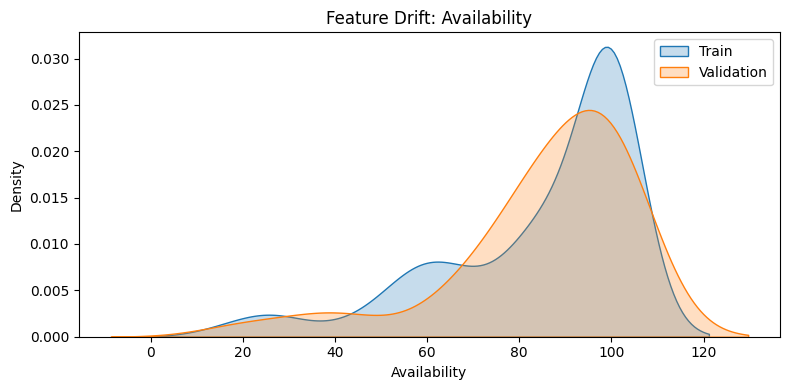

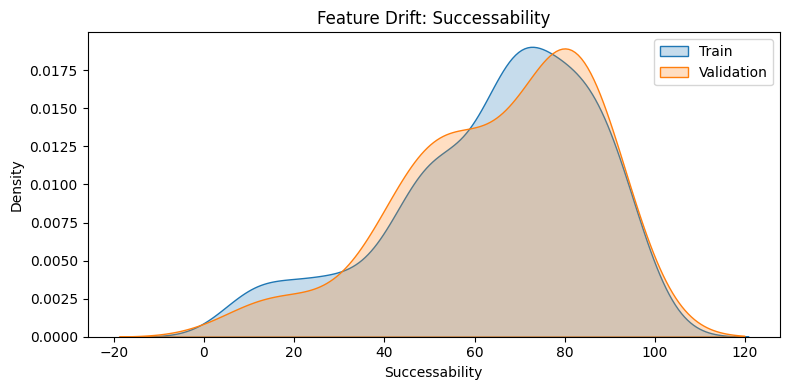

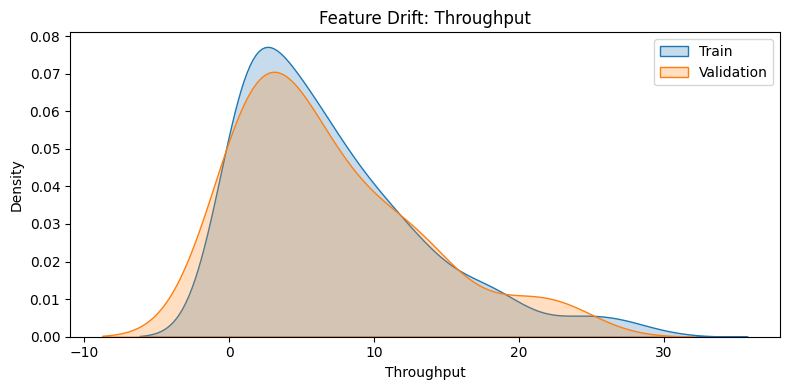

In [7]:
# 7. Plot top 3 drifted features
top_features = df_drift['Feature'].head(3)
for col in top_features:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(X_train[col], label='Train', fill=True)
    sns.kdeplot(X_val[col], label='Validation', fill=True)
    plt.title(f"Feature Drift: {col}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{ARTIFACT_DIR}/drift_{col}.png")
    plt.show()

1. Availability:
- Validation curve shifted right (higher values) compared to training.
- Indicates services in validation set have better availability than training.
- Matches PSI = 1.56 (largest drift).

2. Successability:
- Slight right shift for validation curve.
- Suggests improved successability in validation data.
- PSI confirms significant drift (1.45).

3. Throughput:
- Validation curve shows heavier tail on the right.
- Indicates more high-throughput observations in validation.
- PSI = 0.94 -> strong drift.

---
---
# **5. Summary**
---
---

In [8]:
# Summary Report
summary_md = "# Classification Model Evaluation Report\n\n"

# Metrics from back-test
summary_md += "## Metrics\n"
summary_md += pd.read_csv("backtest_summary_classification.csv").to_markdown() + "\n\n"

# Drift Analysis
summary_md += "## Drift Analysis\n"
summary_md += df_drift.to_markdown() + "\n\n"

# Interpretation
summary_md += "### Drift Interpretation\n"
summary_md += """
- **PSI > 0.25** indicates significant drift. Review top drifted features for potential retraining.
- Features with moderate drift may require monitoring.
- KS p-values > 0.05 suggest shape differences are not statistically significant, but PSI captures magnitude shifts.
\n"""

# Drift plots
summary_md += "## Drift Plots (Top 3 Features)\n"
for col in df_drift['Feature'].head(3):
    summary_md += f"![Drift for {col}]({ARTIFACT_DIR}/Performance Plots)"
summary_md += "## Model Performance Plots\n"
for name in models.keys():
    summary_md += f"![Performance for {name}]({ARTIFACT_DIR}/{name}_confusion for {name}\n"
    summary_md += f"!PR Curve for {name}\n"

# Write to file
with open(os.path.join(ARTIFACT_DIR, "summary_report.md"), "w") as f:
    f.write(summary_md)

print("Summary report created:", f"{ARTIFACT_DIR}/summary_report.md")

Summary report created: artifacts_classification/summary_report.md
